In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: Entropy=0.9747-0.0000j, Loss=0.8550
Epoch 40: Entropy=0.5558-0.0000j, Loss=0.2558
Epoch 80: Entropy=0.3348-0.0000j, Loss=0.0811
Epoch 120: Entropy=0.5101-0.0000j, Loss=0.2116
Epoch 160: Entropy=0.4072-0.0000j, Loss=0.1276
Training started:
Phase: train Epoch: 1/3 Loss: 0.7060 Acc: 0.5082        
Phase: validation   Epoch: 1/3 Loss: 0.6570 Acc: 0.7059        
Phase: train Epoch: 2/3 Loss: 0.6397 Acc: 0.6721        
Phase: validation   Epoch: 2/3 Loss: 0.5424 Acc: 0.8105        
Phase: train Epoch: 3/3 Loss: 0.5695 Acc: 0.7418        
Phase: validation   Epoch: 3/3 Loss: 0.4446 Acc: 0.9477        
Training completed in 3m 30s
Best test loss: 0.4446 | Best test accuracy: 0.9477
Epoch 0: Entropy=0.4413-0.0000j, Loss=0.1165
Epoch 40: Entropy=0.5441-0.0000j, Loss=0.1972
Epoch 80: Entropy=0.3316-0.0000j, Loss=0.0536
Epoch 120: Entropy=0.5067-0.0000j, Loss=0.1654
Epoch 160: Entropy=0.4148-0.0000j, Loss=0.0991
Training started:
Phase: train Epoch: 1/3 Loss: 0.4963 Acc: 0.8156        
P

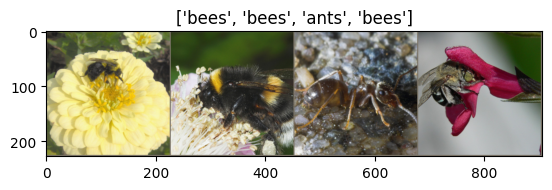

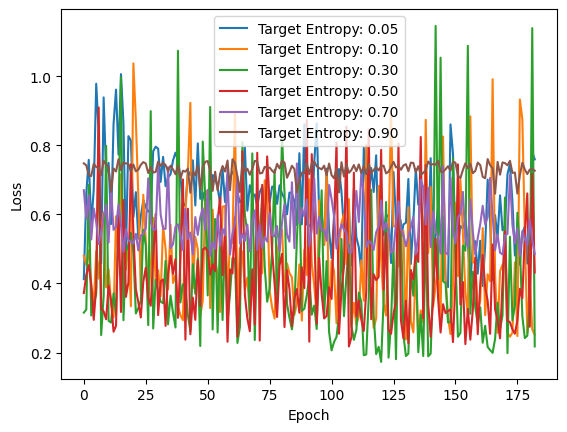

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


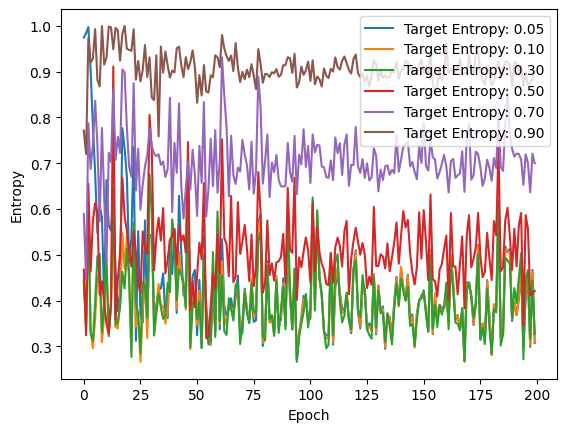

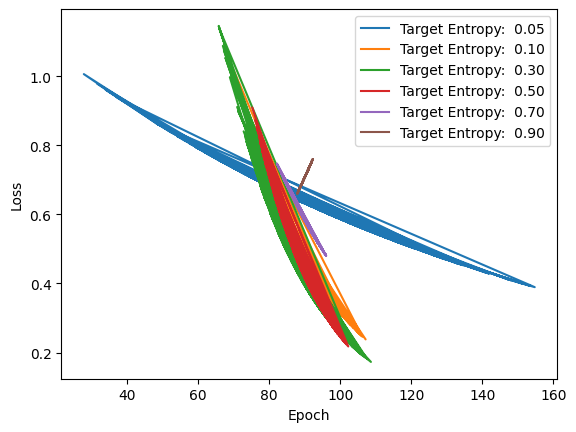

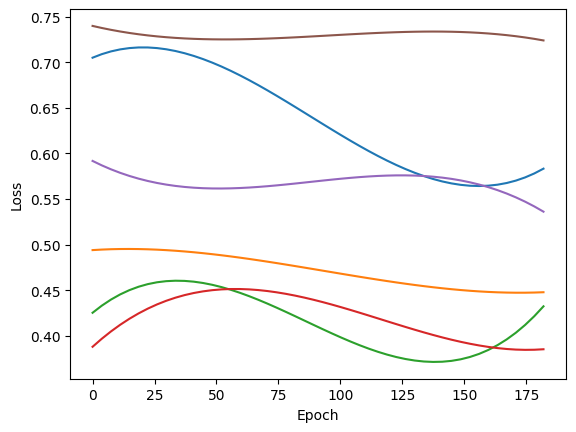

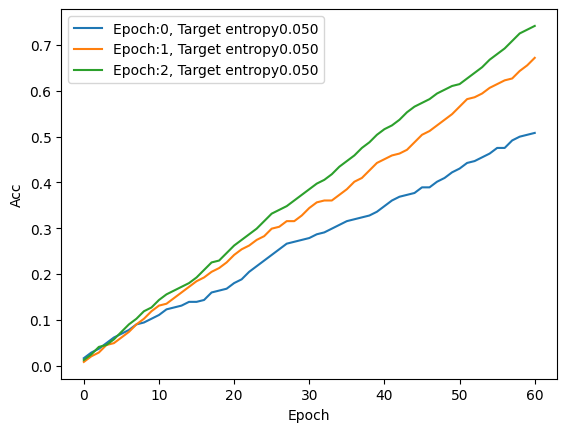

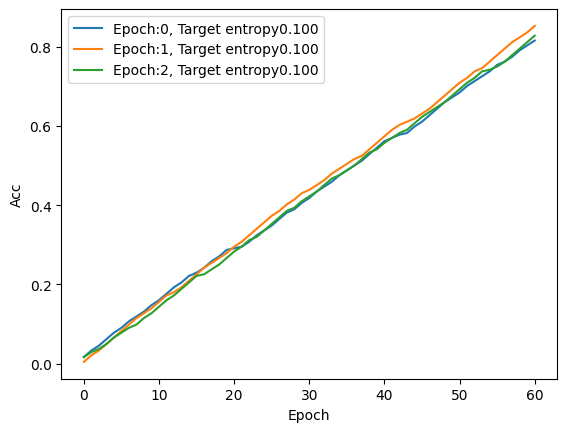

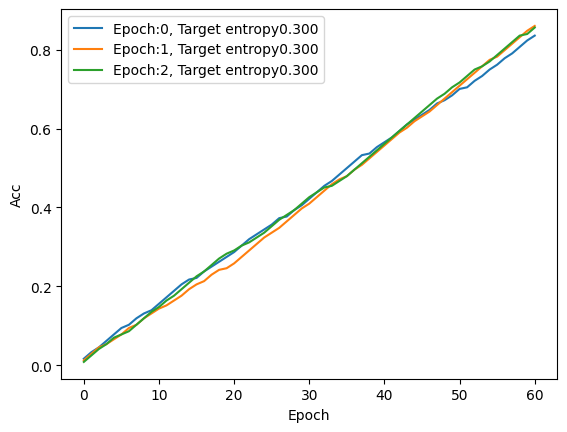

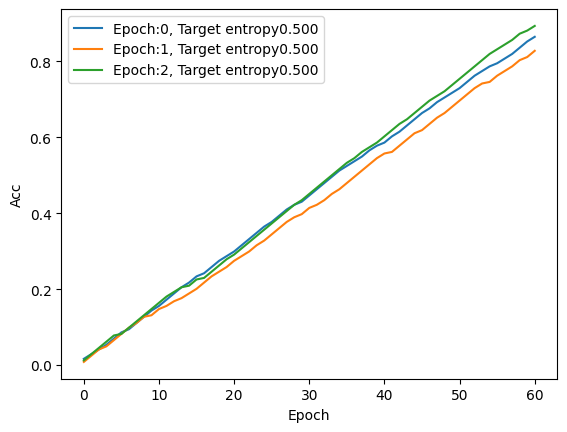

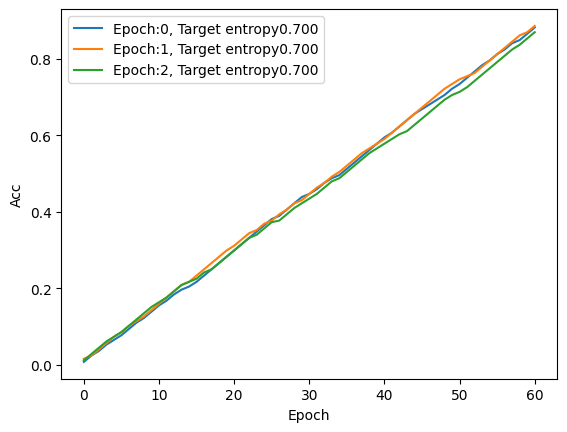

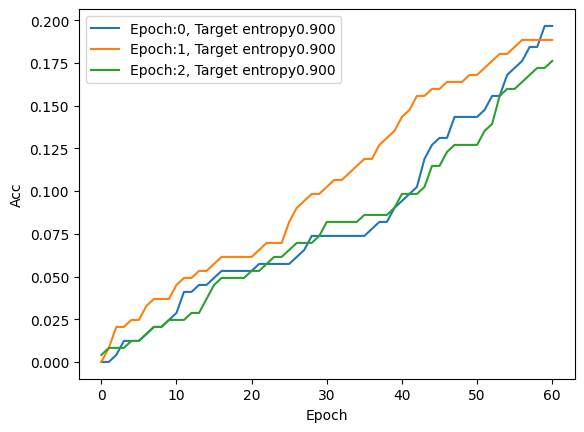

In [ ]:

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(67)
np.random.seed(67)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"


target_entropy = torch.tensor([0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
epoch_for_entropy = 200
lr_for_entropy = 0.1
n_qubits = 4  # Number of qubits
step = 0.0004  # Learning rate
batch_size = 4  # Number of samples for each training step
num_epochs = 3  # Number of training epochs
q_depth = 6  # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.01  # Learning rate reduction applied every 10 epochs.
q_delta = 0.01  # Initial spread of random quantum weights
start_time = time.time()  # Start of the computation timer
all_entropy = []
all_loss = []

# Initialize circuit parameters
psi = Variable(torch.rand(4), requires_grad=True)
alpha = Variable(torch.rand(4), requires_grad=True)

# inputs random parameters
inputs1 = torch.rand(epoch_for_entropy, 4)
inputs2 = torch.rand(1, 24)
"""We initialize a PennyLane device with a `default.qubit` backend.

"""

dev = qml.device("default.qubit", wires=n_qubits)

"""We configure PyTorch to use CUDA only if available. Otherwise the CPU is
used.

"""

device = torch.device("cpu")



data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/drive/MyDrive/Colab Notebooks/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}


# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


"""Let us show a batch of the test data, just to have an idea of the
classification problem.

"""

# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

"""Variational quantum circuit
===========================

We first define some quantum layers that will compose the quantum
circuit.

"""


def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def RX_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])




@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat, entropy_train_weights1, entropy_train_weights2):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node

    RY_layer(q_input_features)

    RY_layer(entropy_train_weights1)

    RX_layer(entropy_train_weights2)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis

    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


@qml.qnode(dev, interface="torch")
def quantum_net1(q_input_features, q_weights_flat, entropy_train_weights1, entropy_train_weights2):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node

    RY_layer(q_input_features)

    RY_layer(entropy_train_weights1)

    RX_layer(entropy_train_weights2)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis

    exp_vals = qml.density_matrix([1])
    return (exp_vals)


"""Dressed quantum circuit
=======================

"""

# Calculate density matrix of the circuit given parameters
def calculate_density_matrix(phi, theta, psi, alpha):
    density_matrix = quantum_net1(phi, theta, psi, alpha)
    return density_matrix


# Calculate second Renyi entanglement entropy of the circuit
def calculate_entropy(density_matrix):
    entropy = -torch.log2(torch.trace(density_matrix ** 2))
    return entropy


# Calculate cost function using entanglement entropy and target value of entanglement entropy
def cost(entropy, target):
    return torch.abs(entropy - target) ** 2


# Train the circuit to minimize the difference between its entropy and target entropy
def entropy_train_model(phi, theta, psi, alpha, target, epoch, lr):
    opt = torch.optim.Adam([psi, alpha], lr=lr)
    all_entropy = []

    for i in range(epoch):
        opt.zero_grad()
        density_matrix = calculate_density_matrix(phi[i], theta, psi, alpha)
        entropy = calculate_entropy(density_matrix)
        loss = cost(entropy, target)
        if i % 40 == 0:
            print(f"Epoch {i}: Entropy={entropy:.4f}, Loss={loss:.4f}")
        loss.backward()
        opt.step()
        all_entropy.append(entropy.detach().numpy())

    return psi, alpha, all_entropy



class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        # print(input_features.size())
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)

        checkpoint = torch.load('my_model.pt')
        params1 = checkpoint['params1']
        params2 = checkpoint['params2']

        # q_in = q_in.clone().detach().requires_grad_(True)
        # params = entropy_train_model(q_in, self.q_params)

        for elem in (q_in):
            q_out_elem = quantum_net(elem, self.q_params, params1, params2).float().unsqueeze(0)

            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)


"""Hybrid classical-quantum model
==============================

"""

model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

"""Training and results
====================

"""

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)


def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):
        loss_for_epoch=[]
        acc_for_epoch=[]
        epoch_loss_table=[]
        epoch_acc_table=[]

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:

            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:

                since_batch = time.time()
                batch_size_ = len(inputs)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    # params = entropy_train_model(inputs1, inputs2, psi)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss_for_epoch.append(loss)#.detach().numpy())
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                if phase == "train":
                    acc_for_epoch.append(running_corrects / dataset_sizes[phase])
                
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == "train":
                epoch_loss_table.append(epoch_loss)
                epoch_acc_table.append(epoch_acc)
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()
        
        all_loss_for_epoch.append(loss_for_epoch)
        all_acc_for_epoch.append(acc_for_epoch)
        all_epoch_loss_table.append(epoch_loss_table)
        all_epoch_acc_table.append(epoch_acc_table)
        

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))

    all_loss_for_epochs = torch.cat([torch.stack(row) for row in all_loss_for_epoch], dim=0)
    return model, all_loss_for_epochs, all_acc_for_epoch,  all_epoch_loss_table, all_epoch_acc_table

result_list_loss = []
result_list_acc = []
result_all_epoch_loss_table=[]
result_all_epoch_acc_table=[]
all_acc_for_epochs1 = []
entropy_=[]
"""
We are ready to perform the actual training process.

"""


for i in range(len(target_entropy)):

     all_loss_for_epoch = []
     all_acc_for_epoch = []
     all_epoch_loss_table= []
     all_epoch_acc_table= []

     trained_psi, trained_alpha, entropy_ = entropy_train_model(inputs1, inputs2, psi, alpha, target_entropy[i], epoch_for_entropy, lr_for_entropy)
     # Save the trained parameters
     torch.save({'params1': trained_psi, 'params2': trained_alpha}, 'my_model.pt')
     all_entropy.append(entropy_)
     model_hybrid, all_loss_for_epoch, all_acc_for_epoch, all_epoch_loss_table, all_epoch_acc_table= train_model(
         model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)
     
     result_list_loss.append(all_loss_for_epoch)
     result_list_acc.append(all_acc_for_epoch)
     result_all_epoch_loss_table.append(all_epoch_loss_table)
     result_all_epoch_acc_table.append(all_epoch_acc_table)

def generate_plots(target_entropy, result_list_loss, all_entropy, result_list_acc):
    
    # Plot of loss vs epoch for each target entropy
    fig, ax = plt.subplots()
    for i in range(len(target_entropy)):
        ax.plot(range(183), (result_list_loss[i].detach().numpy()), label=f"Target Entropy: {target_entropy[i]:.2f}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    # Plot of entropy vs epoch for each target entropy
    fig, ax = plt.subplots()
    for i in range(len(target_entropy)):
        ax.plot(range(200), (all_entropy[i]), label=f"Target Entropy: {target_entropy[i]:.2f}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Entropy')
    ax.legend()
    plt.show()

    # Plot of loss vs log(loss) for each target entropy
    fig, ax = plt.subplots()
    for i in range(len(target_entropy)):
        a = np.polyfit(np.log(result_list_loss[i].detach().numpy()), (range(183)), 1)
        y = a[0] * (np.log(result_list_loss[i].detach().numpy())) + a[1]
        ax.plot(y ,(result_list_loss[i].detach().numpy()), label=f"Target Entropy:  {target_entropy[i]:.2f}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    # Plot of loss vs epoch with a polynomial fit (degree 3) for each target entropy
    for i in range(len(target_entropy)):
        x = range(183)
        y = result_list_loss[i].detach().numpy()

        # calculate polynomial
        z = np.polyfit(x, y, 3)
        f = np.poly1d(z)

        # calculate new x's and y's
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)

        plt.plot(x_new, y_new, label=f"Target Entropy:  {target_entropy[i]:.3f}")

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
    plt.show()

    # Plot of accuracy vs epoch for each target entropy and epoch
    for i in range(len(target_entropy)):
        fig, ax = plt.subplots()
        for j in range(3):
            ax.plot(range(61), (result_list_acc[i][j]), label=f"Epoch:{j}, Target entropy{target_entropy[i]:.3f}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Acc')
        ax.legend()
        plt.show()

generate_plots(target_entropy, result_list_loss, all_entropy, result_list_acc)

In [ ]:
import pandas as pd
from tabulate import tabulate
# Define the number of epochs
num_epochs = 3

# Define the loss and accuracy data
 
loss_data = [[inner[0] for inner in outer] for outer in result_all_epoch_loss_table]
acc_data = [[inner[0] for inner in outer] for outer in result_all_epoch_acc_table]



# Define the table headers
headers = ['Target Entropy', 'Epoch 1', 'Epoch 2', 'Epoch 3']

# Define the table data
table_data = []
for i in range(len(loss_data)):
    row = [f'{target_entropy[i]:.3f}'] + [f'Loss {loss_data[i][j]:.2f}/ Acc {acc_data[i][j]:.2f}' for j in range(3)]
    table_data.append(row)

# Print the table
print(tabulate(table_data, headers=headers, tablefmt='fancy_grid'))


╒══════════════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│   Target Entropy │ Epoch 1             │ Epoch 2             │ Epoch 3             │
╞══════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│             0.05 │ Loss 0.71/ Acc 0.51 │ Loss 0.64/ Acc 0.67 │ Loss 0.57/ Acc 0.74 │
├──────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│             0.1  │ Loss 0.50/ Acc 0.82 │ Loss 0.46/ Acc 0.85 │ Loss 0.46/ Acc 0.83 │
├──────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│             0.3  │ Loss 0.44/ Acc 0.84 │ Loss 0.40/ Acc 0.86 │ Loss 0.40/ Acc 0.86 │
├──────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│             0.5  │ Loss 0.43/ Acc 0.86 │ Loss 0.45/ Acc 0.83 │ Loss 0.39/ Acc 0.89 │
├──────────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│             0.7  │ Loss 0.57/ Acc 0.88 │ 

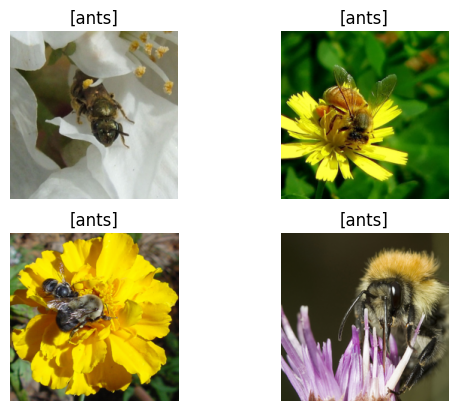

In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
visualize_model(model_hybrid, num_images=batch_size)
plt.show()